In [17]:
import numpy as np
import pandas as pd
import random
import torch
import dgl
import os
import sys

import matplotlib.pyplot as plt


# 현재 파일의 상위 디렉토리를 sys.path에 추가
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [18]:
# 폰트 설정
import matplotlib as mpl
import matplotlib.font_manager as fm

font_path = r"C:\Windows\Fonts\malgun.ttf"  
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

In [19]:
# 재현성 난수 고정
def SET_SEED():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    dgl.random.seed(SEED)

    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 100
SET_SEED()

In [20]:
dataset = 'logvp' # freesolv / esol / lipo / logp / logvp
save_dir = r'..\results_figure'

In [21]:
# 상황분류
df_class = pd.read_excel(r'..\datasets\vp_class3_1remove.xlsx')

df_class.dropna(inplace = True)
df_class['logvp'] = np.log(df_class['vapor pressure'])
df_class.reset_index(drop = True, inplace = True)
df_class.head()

,smiles,vapor pressure,Name,class2,class3,logvp
0,C=C,52100.0,Ethylene,fire,fire,10.860920
1,C(=O)=O,48300.0,Carbon dioxide,fire,fire,10.785187
2,Cl,35424.0,Hydrogen chloride,terror,terror,10.475145
3,P,29300.0,Phosphamine,terror,poison,10.285343
4,Br,18410.0,Hydrogen bromide,fire,fire,9.820649


In [22]:
smiles_list = df_class['smiles'].tolist()

# target 정의
target = df_class.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['C=C', 'C(=O)=O', 'Cl', 'P', 'Br']
0    10.860920
1    10.785187
2    10.475145
3    10.285343
4     9.820649
Name: logvp, dtype: float64


In [23]:
from utils.utils import MolecularFeatureExtractor
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features

num_all_features = df_all_features.shape[1] - 1 
print("초기 변수 개수:", num_all_features)

# na handling
# NA 확인
df_all_features[df_all_features.isna().any(axis = 1)] # 행방향

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_all_features.isna().any(axis = 0).sum(), '\n')
print(df_all_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_all_features.isna().any(axis = 1).sum(), '\n')
print(df_all_features.isna().any(axis = 1))

df_removed_features = df_all_features.dropna()

# 결측치가 포함된 feature 제거
# df_removed_features = df_all_features.dropna(axis = 1)
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features)

# 결측치가 제거된 data frame
df_removed_features

# 결측치가 포함된 feature 개수
print('결측치가 포함된 열 개수:', df_removed_features.isna().any(axis = 0).sum(), '\n')
print(df_removed_features.isna().any(axis = 0))

print('결측치가 포함된 행 개수:', df_removed_features.isna().any(axis = 1).sum(), '\n')
print(df_removed_features.isna().any(axis = 1))



# nunique == 1 인 경우는 제
unique_columns = list(df_removed_features.loc[:, df_removed_features.nunique() == 1].columns)
print('nunique == 1인 feature : \n', unique_columns, '\n')

# nunique == 1인 feature 제거
#df_removed_features.drop(columns = unique_columns, inplace = True)
df_removed_features = df_removed_features.drop(columns = unique_columns).copy()

num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)


# 너무 낮은 vairnace를 가지는 경
low_variances = sorted(df_removed_features.var())
low_variances[:10]

columns_low_variances = []

for i in low_variances:
    if i < 0.001:
        column = df_removed_features.loc[:, df_removed_features.var() == i].columns
        columns_low_variances.append(column)
columns_low_variances = [item for index in columns_low_variances for item in index]

# 2. 중복 제거 및 유니크 값 추출
columns_low_variances = list(set(columns_low_variances))
print(columns_low_variances)

# 낮은 분산의 변수 제거
df_removed_features = df_removed_features.drop(columns = columns_low_variances).reset_index(drop=True).copy()
num_removed_features = df_removed_features.shape[1] - 1  # logvp 열 제외

print("제거 후 남은 feature 개수:", num_removed_features, '\n')
print(df_removed_features.shape)

df_removed_features

초기 변수 개수: 208
결측치가 포함된 열 개수: 12 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          False
fr_thiophene         False
fr_unbrch_alkane     False
fr_urea              False
target               False
Length: 209, dtype: bool
결측치가 포함된 행 개수: 1 

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19     True
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
dtype: bool
제거 후 남은 feature 개수: 208
결측치가 포함된 열 개수: 0 

MaxEStateIndex       False
MinEStateIndex       False
MaxAbsEStateIndex    False
MinAbsEStateIndex    False
qed                  False
                     ...  
fr_thiocyan          Fal

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_halogen,fr_hdrzine,fr_nitrile,fr_nitro,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_sulfide,fr_unbrch_alkane,target
0,3.000000,3.000000,3.000000,3.000000,0.344497,28.054,24.022,28.031300,12,0,...,0,0,0,0,0,0,0,0,0,10.860920
1,8.125000,0.250000,8.125000,0.250000,0.364167,44.009,44.009,43.989829,16,0,...,0,0,0,0,0,0,0,0,0,10.785187
2,0.000000,0.000000,0.000000,0.000000,0.365164,36.461,35.453,35.976678,8,0,...,1,0,0,0,0,0,0,0,0,10.475145
3,0.000000,0.000000,0.000000,0.000000,0.332023,33.998,30.974,33.997237,8,0,...,0,0,0,0,0,0,0,0,0,10.285343
4,0.000000,0.000000,0.000000,0.000000,0.399656,80.912,79.904,79.926162,8,0,...,1,0,0,0,0,0,0,0,0,9.820649
5,2.180556,1.319444,2.180556,1.319444,0.431024,58.124,48.044,58.078250,26,0,...,0,0,0,0,0,0,0,0,0,7.506592
6,11.208912,-6.072338,11.208912,3.754630,0.526121,200.028,200.028,199.987226,72,0,...,8,0,0,0,0,0,0,0,0,7.461640
7,8.975309,-0.888889,8.975309,0.888889,0.421051,98.916,98.916,97.932620,24,0,...,2,0,0,0,0,0,0,0,0,7.258412
8,7.084877,1.222222,7.084877,1.222222,0.404573,61.471,61.471,60.971927,16,0,...,1,0,1,0,0,0,0,0,0,7.114769
9,8.000000,1.000000,8.000000,1.000000,0.281642,46.005,46.005,45.992903,17,1,...,0,0,0,0,0,0,0,0,0,6.802395


In [24]:
# 3분류
class_list = df_class.set_index('logvp')['class3'].to_dict()
df_removed_features['class'] = df_removed_features['target'].map(class_list)

# tSNE & PCA

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [26]:
X = np.array(df_removed_features.drop(columns = ['target', 'class']))
X.shape

(31, 144)

In [27]:
perplexity = 5
method = 'exact' # default: barnes_hut, 'exact'
learning_rate = 100
n_iter =3000

In [28]:
tsne = TSNE(n_components = 2, random_state = SEED, perplexity = perplexity, method = method, learning_rate = learning_rate, n_iter = n_iter)
tsne3D = TSNE(n_components = 3, random_state = SEED, perplexity = perplexity, method = method, learning_rate = 100, n_iter = n_iter)

X_tsne = tsne.fit_transform(X)
X_tsne3D = tsne3D.fit_transform(X)

In [29]:
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

In [30]:
label_colors = {'fire': 'red',
                'terror': 'blue',
                'poison': 'green'}

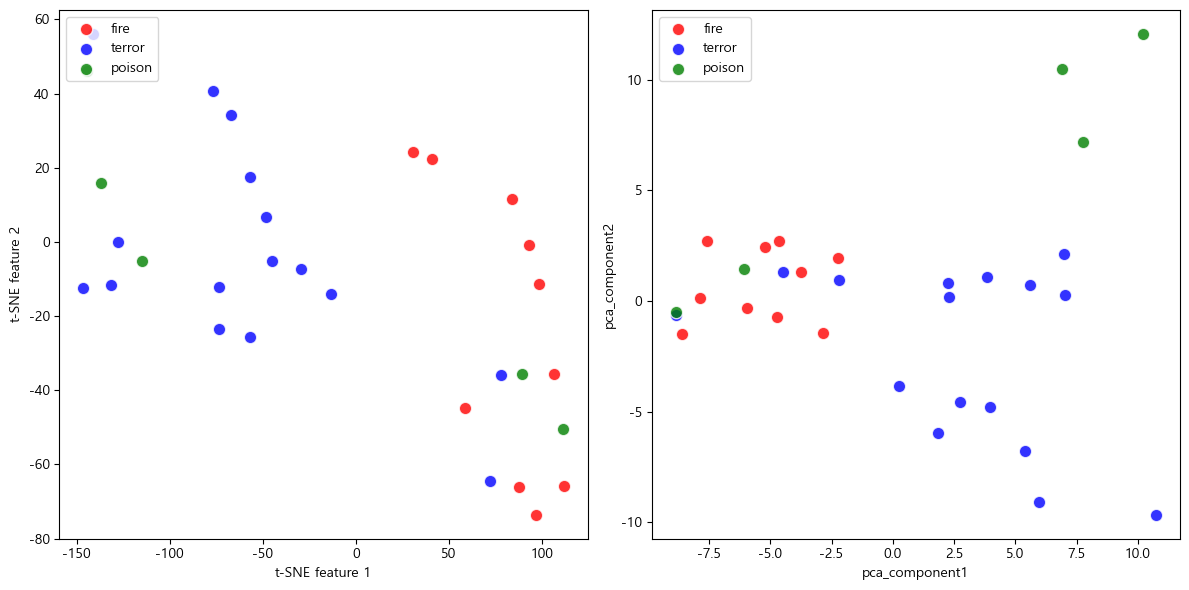

In [31]:
# t-SNE vs. PCA 2D
fig = plt.figure(figsize = (12, 6))

ax1 = plt.subplot(1, 2, 1)
for cls, color in label_colors.items():
    mask = df_removed_features['class'] == cls
    idxs = np.where(mask)[0]
    ax1.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1],
                c = color, label = cls, s = 80, alpha = 0.8, edgecolors='w')

# ax1.set_title('t-SNE 2D Visualization by Class')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend(loc = 'upper left')

ax2 = plt.subplot(1, 2, 2)
for cls, color in label_colors.items():
    idxs = np.where(df_removed_features['class']==cls)[0]
    ax2.scatter(X_pca2D[idxs, 0], X_pca2D[idxs, 1], 
                c = color, label = cls, s = 80, alpha = 0.8, edgecolors='w')

# ax2.set_title('PCA 2D Visualization by Class')
ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.legend(loc='upper left')

plt.tight_layout()

# # 저장
# file_name = f'scatter_pred_mse_{dataset}.png'
# file_path = os.path.join(save_dir, file_name)
# print(file_path)
# plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')

plt.show()

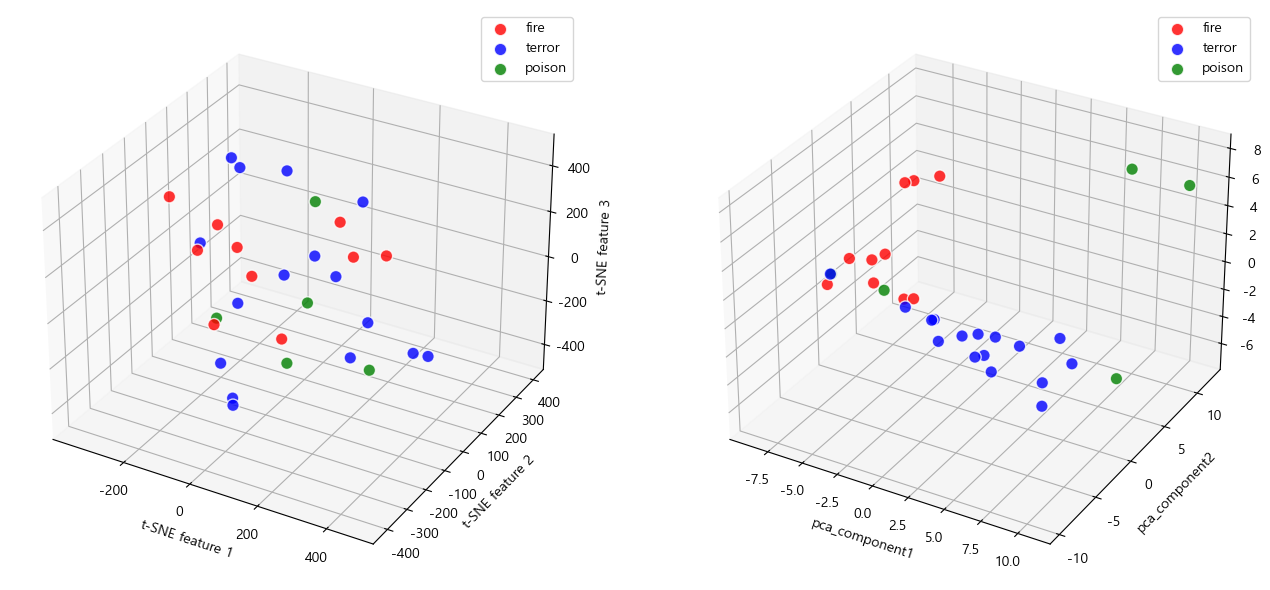

In [32]:
# t-SNE vs. PCA 3D
fig = plt.figure(figsize = (14, 6))

ax1 = fig.add_subplot(1,2,1, projection = '3d')
for cls, color in label_colors.items():
    mask = df_removed_features['class'] == cls
    idxs = np.where(df_removed_features['class'] == cls)[0]
    ax1.scatter(X_tsne3D[idxs, 0], X_tsne3D[idxs, 1], X_tsne3D[idxs, 2],
                c = color, label = cls, s = 80, alpha = 0.8, edgecolors='w')

# ax1.set_title('t-SNE 3D Visualization by Class')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend(loc = 'best')

ax2 = fig.add_subplot(1,2,2, projection = '3d')
for cls, color in label_colors.items():
    idxs = np.where(df_removed_features['class']==cls)[0]
    ax2.scatter(X_pca3D[idxs, 0], X_pca3D[idxs, 1], X_pca3D[idxs, 2],
                c = color, label = cls, s = 80, alpha = 0.8, edgecolors='w')

# ax2.set_title('PCA 3D Visualization by Class')
ax2.set_xlabel('pca_component1')
ax2.set_ylabel('pca_component2')
ax2.set_zlabel('pca_component3')
ax2.legend(loc = 'best')

plt.tight_layout()

# 저장
# file_name = f'scatter_pred_mse_{dataset}.png'
# file_path = os.path.join(save_dir, file_name)
# print(file_path)
# plt.savefig(file_path, dpi = 300, bbox_inches = 'tight')

plt.show()